In [5]:
pip install ipympl ipyplot umap-learn albumentations pydot mlxtend seaborn tensorflow_model_optimization tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 2.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipyplot as plt2
import seaborn as sns
import pandas as pd

raw_x = np.load("./data/train/train_images.npy")
raw_y = pd.read_csv("./data/train/train_labels.csv")
label2txt = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
raw_y["txtlabel"] = [label2txt[i] for i in raw_y["label"]]

# Labels
Each training and test example is assigned to one of the following labels:

| Label |	Description  |
|-------|----------------|
|   0   |	T-shirt/top  |
|   1   |	Trouser      |
|   2   |	Pullover     |
|   3   |	Dress        |
|   4   |	Coat         |
|   5   |	Sandal       |
|   6   |	Shirt        |
|   7   |	Sneaker      |
|   8   |	Bag          |
|   9   |	Ankle boot   |


# EDA

## Dataset sample viewing

In [ ]:
txtlabels = [label2txt[i] for i in raw_y["label"]]
plt2.plot_class_tabs(raw_x, txtlabels, img_width=28, show_url=False, zoom_scale=3)

## Classes mean element vector

In [ ]:
class_mean_x = [np.mean(raw_x[raw_y["label"]==i], (0)) for i in range(10)]
plt2.plot_images(class_mean_x)

## Per Class pixel intensity histogram

In [ ]:
fig, axes = plt.subplots(5, 2, )
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_tight_layout(True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i, j].hist(raw_x[raw_y["label"]==(2*i+j)].flatten(), bins=20, density=True, range=(0.1, 255))
        axes[i,j].set_title(label2txt[2*i+j])
        
plt.show()

## PCA Dimension reduction

In [ ]:
import sklearn.decomposition as dec

In [ ]:
mean_x = np.mean(class_mean_x, 0)
mean_norm_x = raw_x - [mean_x for i in range(len(raw_x))]
flatten_x = np.array([img.flatten() for img in raw_x])

In [ ]:
PCA_x = dec.PCA(n_components=3).fit_transform(flatten_x)
pca_df = pd.DataFrame.copy(raw_y)
pca_df["first dim"] = PCA_x[..., 0]
pca_df["second dim"] = PCA_x[..., 1]
pca_df["third dim"] = PCA_x[..., 2]
pca_df["txtlabel"] = txtlabels
pca_df

In [ ]:
pca_3d_scatter = plt.figure()
ax = pca_3d_scatter.add_subplot(projection='3d')

ax.scatter3D(
    xs=pca_df["first dim"], ys=pca_df["second dim"], zs=pca_df["third dim"],
    c=pca_df["label"], 
    cmap='tab10',   
)
plt.show()

## t-SNE analisys

In [ ]:
import sklearn.manifold as mf

In [ ]:
tsne_x = mf.TSNE(n_components=2, verbose=1, perplexity=40).fit_transform(flatten_x[:10000])

tsne_df = pd.DataFrame()
tsne_df["label"] = txtlabels[:10000]
tsne_df["1d"] = tsne_x[..., 0]
tsne_df["2d"] = tsne_x[..., 1]

plt.figure()
sns.scatterplot(
    x="1d", y="2d",
    hue="label",
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("hls", 10),
    data=tsne_df,

)
plt.show()

## UMap analysis

In [ ]:
import umap.umap_ as umap
import umap.plot as umap_plot

In [ ]:
mapper = umap.UMAP().fit(flatten_x[:30000])

In [ ]:
umap_plot.output_notebook()
hover_data_df = pd.DataFrame({"Class": txtlabels[:30000]})
p = umap_plot.interactive(mapper, labels=txtlabels[:30000], hover_data=hover_data_df, point_size=2, theme='fire')
umap_plot.show(p)

# Model Training:


In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
%reload_ext autoreload
%autoreload 2
from helper import *

from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, RandomFlip, RandomBrightness
from tensorflow.keras import Sequential, models
from tensorflow_addons.optimizers import CyclicalLearningRate, Triangular2CyclicalLearningRate, TriangularCyclicalLearningRate

metrics=['accuracy', 'AUC']

keras.utils.set_random_seed(seed)

/home/gullino18/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


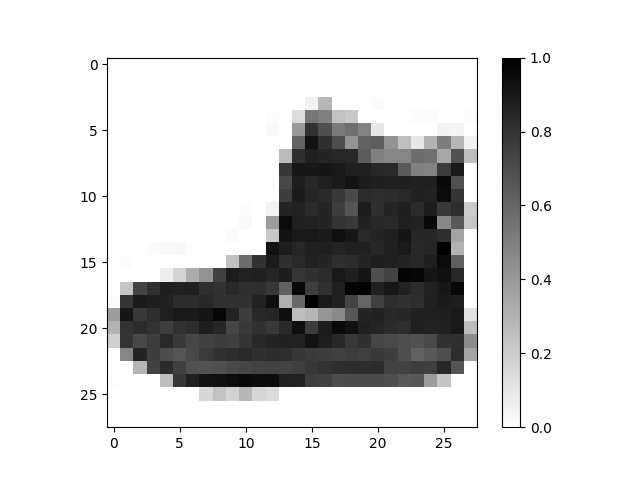

In [7]:
casted_x = np.array(raw_x, dtype="float32")
normalized_x = casted_x / 255
plt.figure()
plt.imshow(normalized_x[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
onehot_y = keras.utils.to_categorical(raw_y["label"], num_classes=10)
split = int(len(normalized_x)*0.9/10)
train_index = [i for i, lab in enumerate(raw_y["label"]) if lab==0][:split]
test_index = [i for i, lab in enumerate(raw_y["label"]) if lab==0][split:]

for j in range(1, 10):
    train_index = train_index + [i for i, lab in enumerate(raw_y["label"]) if lab==j][:split]
    test_index += [i for i, lab in enumerate(raw_y["label"]) if lab==j][split:]

## Simple Softmax model: Base Line


In [ ]:

tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=opt.SGD(learning_rate=.01), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

## Multi Layer Perceptron Models

### HyperParameters Search

In [ ]:
hyperparam_search(normalized_x[train_index], onehot_y[train_index], normalized_x[test_index], onehot_y[test_index])

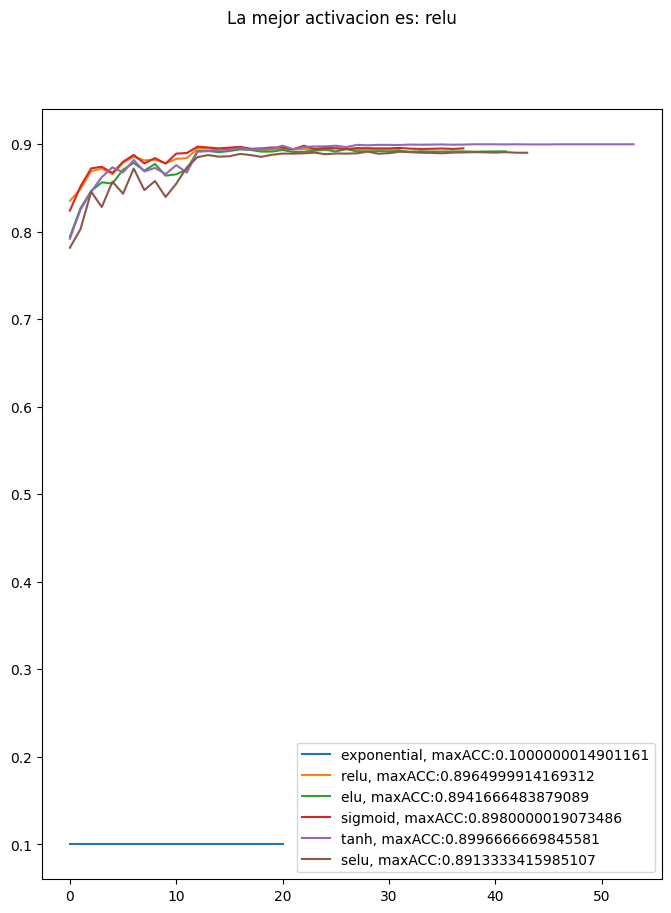

La mejor activacion termina siendo Relu ya que converge rapidamente a un buen valor de accuracy, pero esta prueba no demuestra la superioridad total de Relu sobre otras activaciones ya que todas alcanzan accuracys bastante buenas.

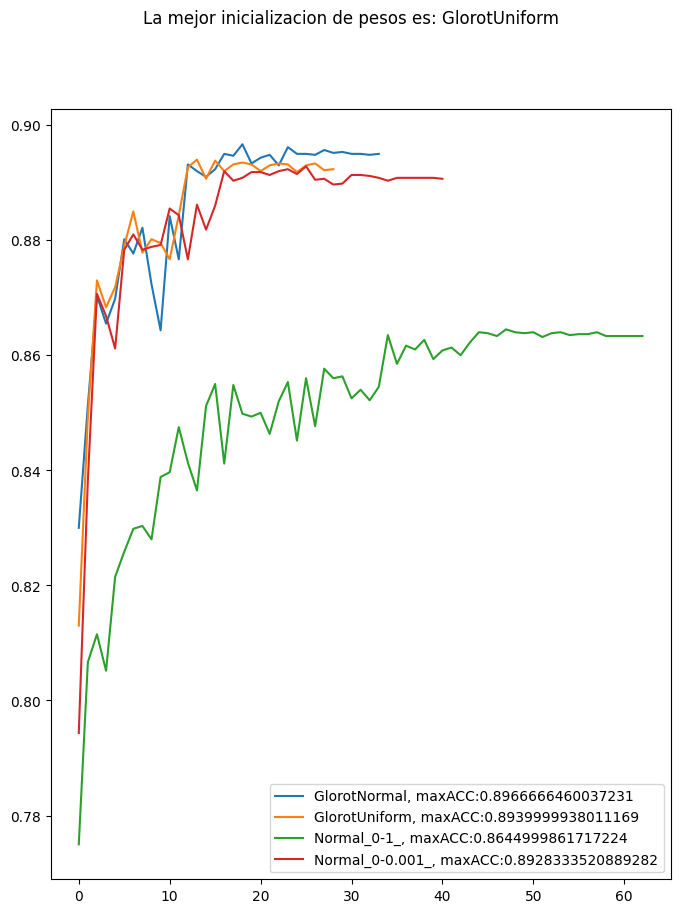

En este caso, el mejor score lo recibe Glorot Normal, pero la Glorot Uniforme alcanza accuracy superior, por lo que se considera mejor para este caso. Y es la que se utilizó a lo largo de toda la busqueda de hyperparametros

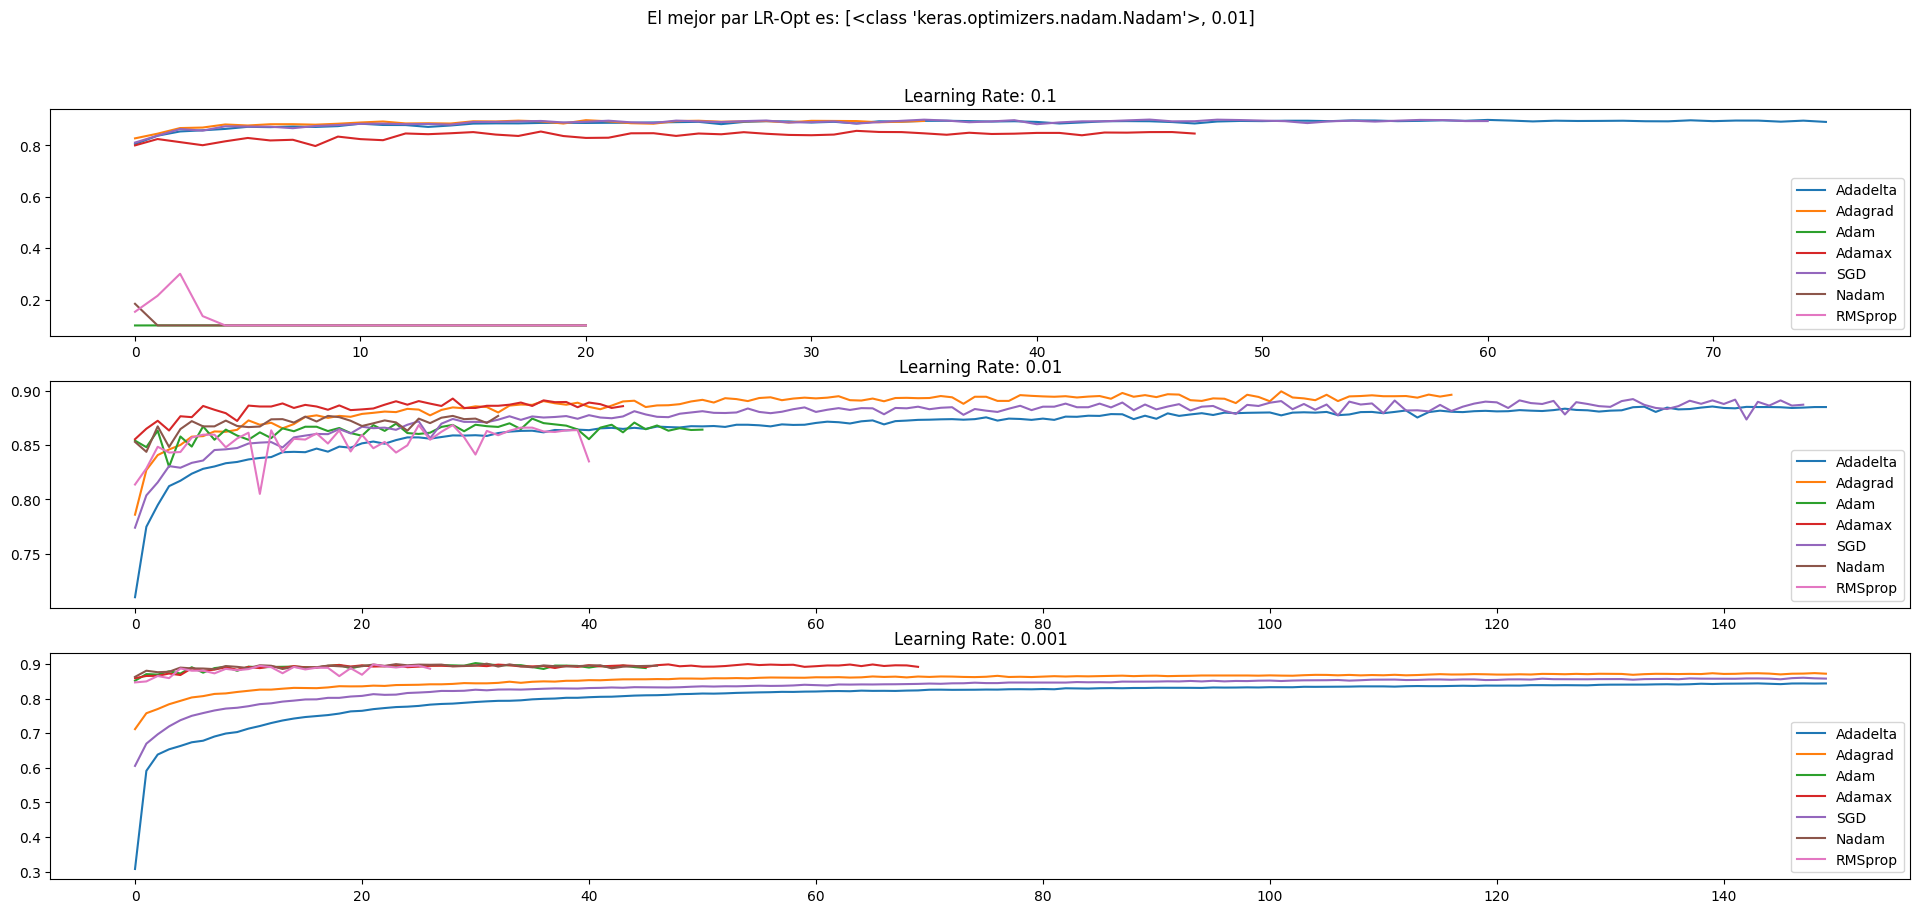

**Recomiendo abrir la imagen por separado**

En este caso se puede ver que para el learning rate mas alto la mayoria de los modelos se comportan de forma similar salvo por Adamax y Nadam, Adam y RMSprop. Para el caso de learning rate 0.01 (mejor learning rate) se puede ver que el mejor modelo es Adamax, pero el score da mejor para Nadam porque se estabiliza antes. Ambos se tendran en cuenta al momento de entrenar, pero predominara Adamax.

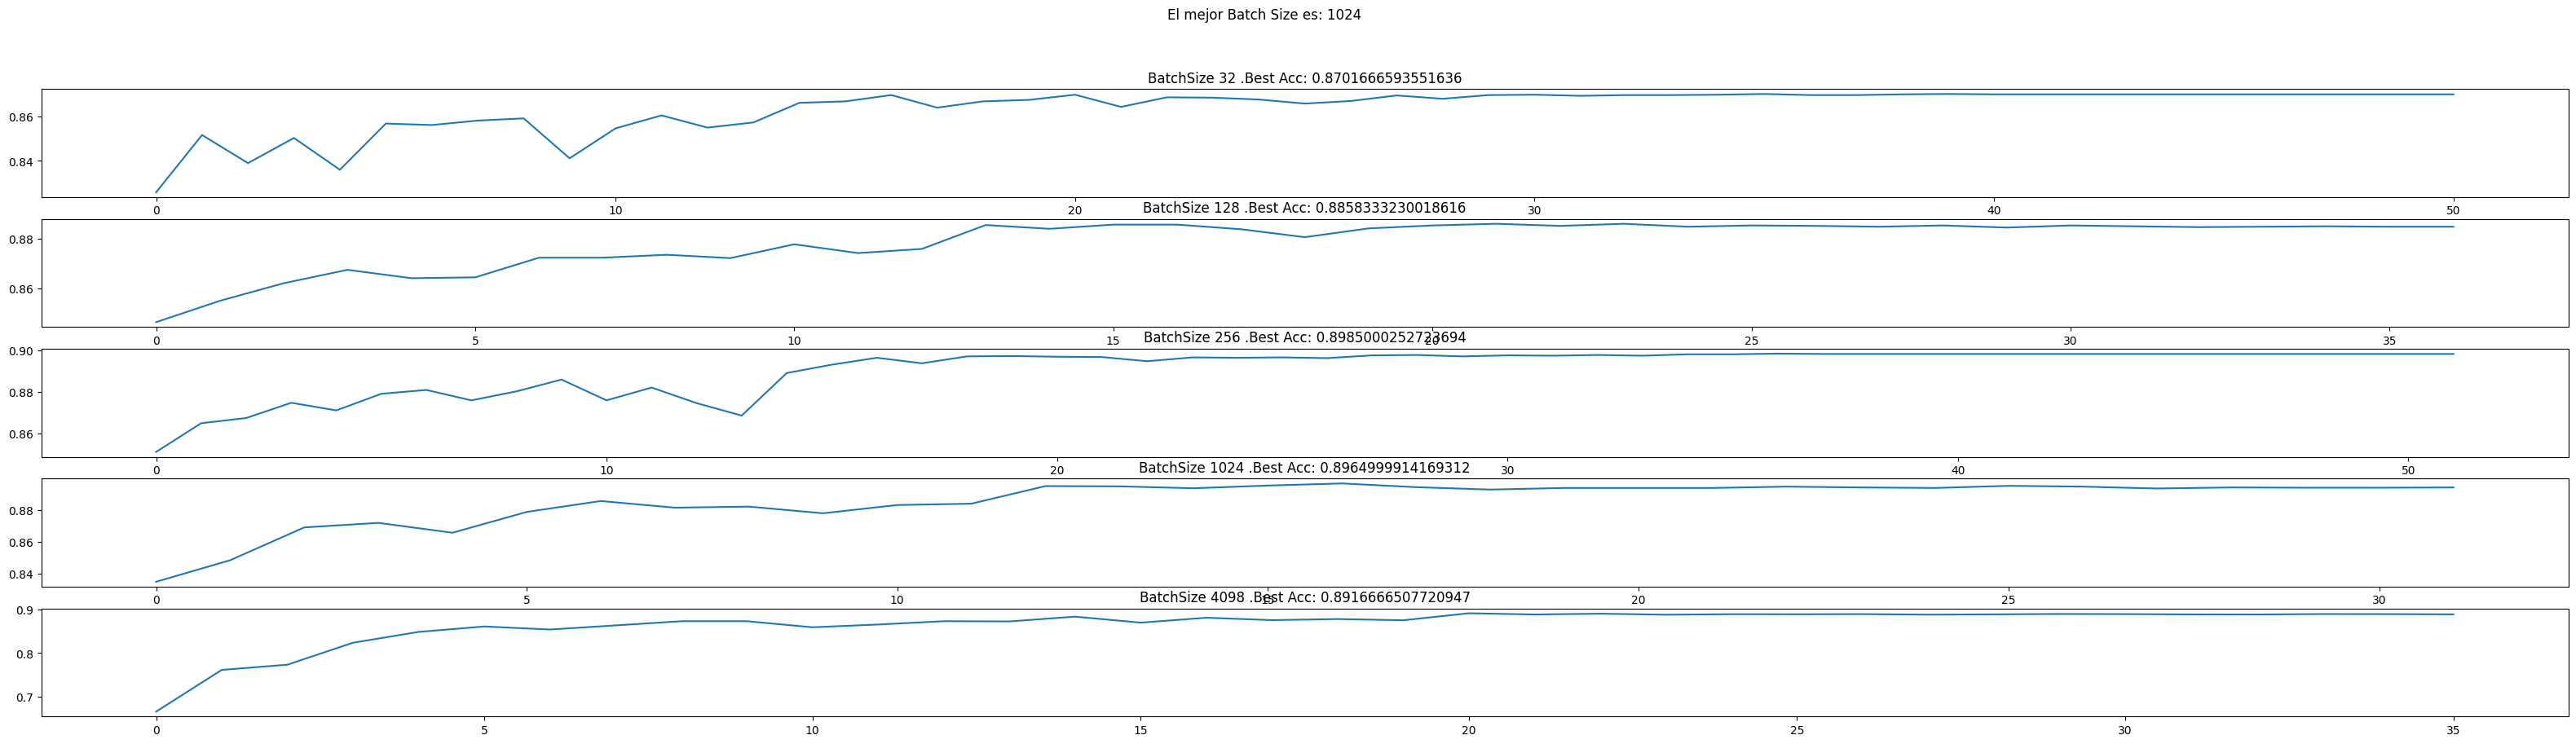

**Recomiendo abrir la imagen por separado**

En este caso el mejor Batch Size se encuentra entre 256 y 1024, se elige 1024 ya que no tiene una mejora significativa frente a un batch size mas chico. Se gana en tiempo de entrenamiento.


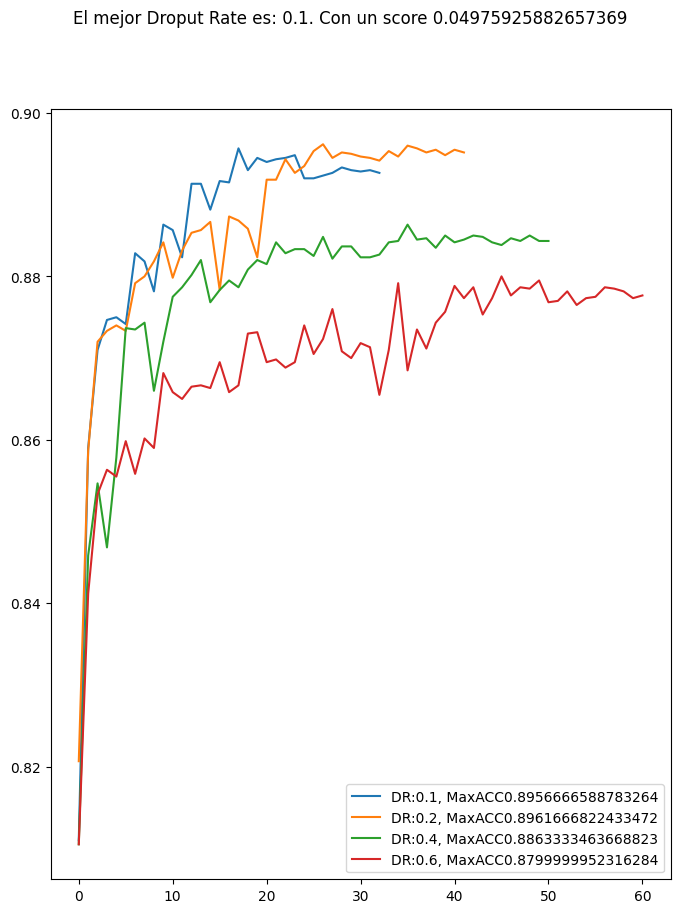

Parece ser que el Dropout rate entre 0.1 y 0.2 es similar, pero prevalece 0.2

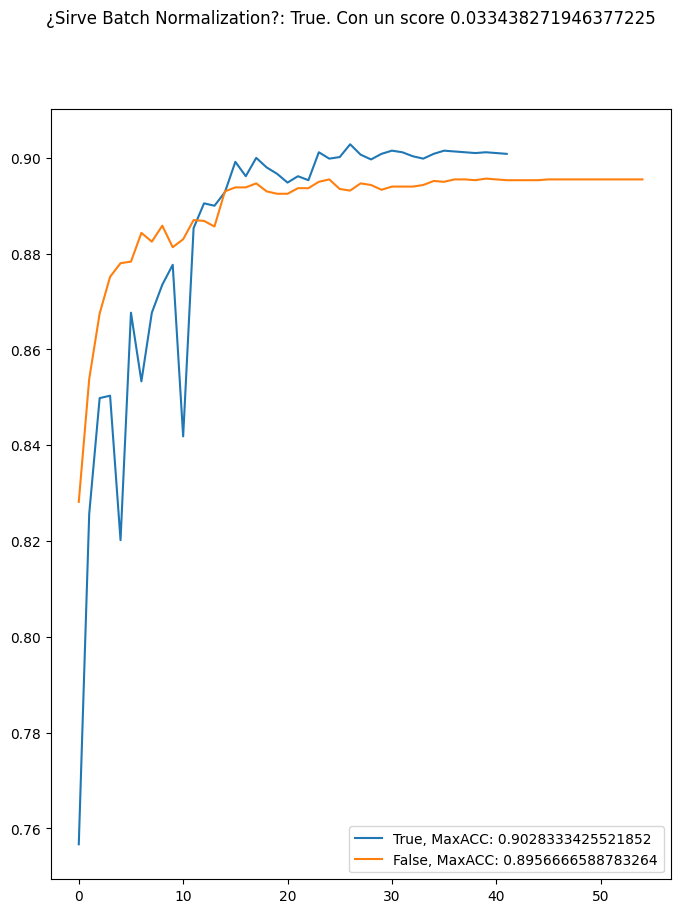

El batch normalization arroja buenos resultados. En las pruebas reales no resulto tan superior.

## Lottery Ticket Hypotesis

### Modelo 1

In [10]:
model1 = Sequential()
model1.add(Flatten(input_shape=(28, 28)))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(10, activation='softmax'))
model1.compile(optimizer=opt.Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)
model1.summary()

model1.save("./LotteryTicketModels/Model1")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model1/assets


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model1/assets


### Modelo 2

In [12]:
model2 = models.load_model("./LotteryTicketModels/Model1")
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model2.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])
model2.save("./LotteryTicketModels/Model2")

Epoch 1/1000
211/211 [==============================] - 9s 35ms/step - loss: 0.7280 - accuracy: 0.7779 - auc_1: 0.9733 - val_loss: 0.4133 - val_accuracy: 0.8448 - val_auc_1: 0.9894 - lr: 0.0100
Epoch 2/1000
211/211 [==============================] - 7s 32ms/step - loss: 0.3787 - accuracy: 0.8630 - auc_1: 0.9907 - val_loss: 0.3727 - val_accuracy: 0.8573 - val_auc_1: 0.9913 - lr: 0.0100
Epoch 3/1000
211/211 [==============================] - 7s 31ms/step - loss: 0.3426 - accuracy: 0.8741 - auc_1: 0.9923 - val_loss: 0.3455 - val_accuracy: 0.8728 - val_auc_1: 0.9917 - lr: 0.0100
Epoch 4/1000
211/211 [==============================] - 7s 32ms/step - loss: 0.3207 - accuracy: 0.8809 - auc_1: 0.9932 - val_loss: 0.3691 - val_accuracy: 0.8617 - val_auc_1: 0.9901 - lr: 0.0100
Epoch 5/1000
211/211 [==============================] - 7s 33ms/step - loss: 0.3038 - accuracy: 0.8878 - auc_1: 0.9938 - val_loss: 0.3276 - val_accuracy: 0.8782 - val_auc_1: 0.9922 - lr: 0.0100
Epoch 6/1000
211/211 [========

INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model2/assets


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model2/assets


### Modelo 3

In [20]:
model2 = models.load_model("./LotteryTicketModels/Model2")
model3 = models.load_model("./LotteryTicketModels/Model1")

weights1 = model3.get_weights()
weights2 = model2.get_weights()
weights3 = [np.zeros(weights1[i].shape) for i in range(len(weights1))]

for i, weights in enumerate(zip(weights1, weights2)):
    if len(weights[0].shape) == 1:
        continue
    diference = np.abs(weights[0]-weights[1])
    y_size, x_size = weights[0].shape
    sorted_indexes = np.argsort(diference.flatten())
    for index in sorted_indexes[:int(len(sorted_indexes)//2)]:
        x_index = int(np.mod(index, x_size))
        y_index = int(index // x_size)
        weights3[i][y_index][x_index] = weights1[i][y_index][x_index]
        
model3.set_weights(weights3)
model3.compile(optimizer=opt.Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)
print("Modelo 2", model2.get_weights()[0][0], "Modelo 1", weights1[0][0], "Modelo 3", model3.get_weights()[0][0])
model3.save("./LotteryTicketModels/Model3NotTrained")



Modelo 2 [ 0.01230371 -0.02899495 -0.05221371  0.01835039  0.01904365 -0.05310939
  0.04929507 -0.02731732  0.03835921 -0.00781916  0.02600957 -0.0290462
  0.04586776  0.04325331  0.02892023  0.0621758   0.0310337  -0.00959515
 -0.02580021  0.03665406 -0.05361938 -0.05532504  0.04817794 -0.05174265
  0.01825645 -0.10429239  0.00240369  0.03707416 -0.03391716  0.00023352
  0.01028131 -0.00554093 -0.05235548  0.01041389 -0.01020641  0.03050822
  0.06932937 -0.0098222   0.04959951  0.04151969  0.0549802  -0.01273795
  0.03296734 -0.06588235 -0.04407133  0.05253733 -0.01533832 -0.00571638
  0.02296977 -0.01319182  0.03423312 -0.03926062  0.06540953 -0.05639161
 -0.00431236  0.02462806  0.0254772   0.05323756  0.05133759 -0.05211506
 -0.00622877  0.01255068 -0.04466309 -0.09767994  0.04876999  0.02802742
  0.01194656  0.04121462 -0.03312702 -0.06322533  0.03420796 -0.01048808
  0.05710606 -0.05834981 -0.0558232  -0.00410955 -0.03503992  0.02741167
 -0.0596449   0.00613086  0.06051934  0.047

INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model3NotTrained/assets


INFO:tensorflow:Assets written to: ./LotteryTicketModels/Model3NotTrained/assets


In [15]:
model3 = models.load_model("./LotteryTicketModels/Model3NotTrained")
results = model3.evaluate(normalized_x[test_index], onehot_y[test_index])

188/188 [==============================] - 1s 4ms/step - loss: 2.2749 - accuracy: 0.1868 - auc_2: 0.5755


In [ ]:
model3 = models.load_model("./LotteryTicketModels/Model3NotTrained")
model3.build()
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model3.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=1024, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])
model3.save("./LotteryTicketModels/Model3Trained")

In [ ]:
model3 = models.load_model("./LotteryTicketModels/Model3Trained")
model2 = models.load_model("./LotteryTicketModels/Model2")
print("Model 2:")
model2.evaluate(normalized_x[test_index], onehot_y[test_index])
print("Model 3:")
model3.evaluate(normalized_x[test_index], onehot_y[test_index])

print(model3.get_weights())

Por algun motivo no puedo lograr que los pesos marcados permanezcan en 0.

## Good Model: classification boundary plot

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Dense(10, activation='softmax'))

clr = Triangular2CyclicalLearningRate(5e-5, 0.01, 5 * 196)
model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=clr), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

In [ ]:
plot_decision_bounds(model, normalized_x[test_index], raw_y["label"][test_index].values)

Muy interesante ver las remeras segregadas al centro por ser las que llevan mas confusion. Le re cuesta aprender esa diferencia

## Submissions

Algunos modelos que dieron los mejores resultados. Son los mejores que consegui

### 0.90420

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=32, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

### 0.90280

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=32, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))


### 0.90320

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=32, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))


### Data augmentation

El Data augmentation no me aporto nada para este modelo ):

#### Model with Augmented Data

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(RandomFlip(mode="horizontal", seed=seed, input_shape=(28,28)))
model.add(Flatten(input_shape=(28,28)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)
model.summary()

#### Model without Augmented Data

In [ ]:
tf.keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)

model = Sequential()
model.add(Flatten(input_shape=(28,28)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer=opt.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=metrics)
model.summary()

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, start_from_epoch=8)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=5e-9, patience=5)
history = model.fit(x=normalized_x[train_index], y=onehot_y[train_index], batch_size=256, epochs=1000, shuffle=True, validation_data=(normalized_x[test_index], onehot_y[test_index]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [ ]:
model_evaluation(onehot_y[test_index], model.predict(normalized_x[test_index]))

## Submission generator

In [ ]:
submission = pd.DataFrame()
data = np.load("./data/test/test_images.npy")/255
submission["id"] = np.arange(len(data))
submission["Category"] = np.argmax(model.predict(data), (1))
submission.to_csv("submission.csv", index=False)
